# Отток клиентов

Компания, осуществляющая банковские услуги, заинтересована в сохранении своих клинтов. Была поставлена задача спрогнозировать - уйдёт клиент из банка в ближайшее время или нет. Для построения модели обучения банк предоставил исторические данные о своих клиентах и факт расторжения договора, если таковой был.

Описание данных:

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — количество недвижимости у клиента
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
display(churn.head(3))
churn.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#Заменим названия столбцов (приведем к нижнему регистру):
churn.columns = churn.columns.str.lower()
display(churn.head(1))

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


In [5]:
#Пропуски (10% от общего числа записей) есть только в столбце "Недвижимость". Каких-то зависимостей у пропусков
#с другими столбцами не обнаружено, поэтому заменим их на -1:
#churn['tenure'] = churn['tenure'].fillna(value=-1).astype('int64')
#Попробовал удалить пропуски - показатели стали хуже. Подробности - в самом конце.
#churn = churn.dropna(subset=['tenure'])
#Попробуем заменить медианой:
tenure_med = churn['tenure'].mean()
churn['tenure'] = churn['tenure'].fillna(value=tenure_med).astype('int64')
#последний вариант чуть предпочтительнее.
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
#Фамилии клиентов нам не нужны, поскольку не влияют на признаки
churn = churn.drop(['rownumber', 'customerid', 'surname'], axis=1)
churn.head(1)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [7]:
#Применим прямое кодирование (OHE):
churn = pd.get_dummies(churn, drop_first=True)
churn.head(1)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.0,1,1,1,101348.88,1,0,0,0


### Вывод

В исходном датафрейме содержится 10000 записей, представляющих собой информацию по конкретным пользователям с указанием индивидуальных данных в т.ч. банковских. Для удобства дальнейшего анализа были переименованы названия столбцов. Пропуски содержадись только в столбце "Недвижимость", которые мы заменили на значение, выходящее за используемый диапазон (в дальнейшем можно попробовать изменить значение с -1 на какое-либо другое в зависимости от показателей F1).<br>
UPD.: заменил пропуски на медиану - показатели немного выросли, поэтому оставил её.<br>
Также изменили тип данных столбца на целочисленный. 

Дополнительно удалили столбец с фамилиями, номером строки и ID клиента и применили Прямое кодирование с обходом дамми-ловушки.

# 2. Исследование задачи

Исследуем баланс классов, обучим модели без учёта дисбаланса.

In [8]:
#Выделим признаки
target = churn['exited']
features = churn.drop('exited', axis=1)

In [9]:
#Поскольку датасет один и нет "спрятанных" тестовых выборок, то разделим данные на 3 выборки:
#обучающую (60%), валидационную (20%) и тестовую (20%) в соотношении 3-1-1 соответственно.
#выделим тестовую выборку (20%):
features_test, features_valid_train, target_test, target_valid_train = train_test_split(
    features, target, test_size=0.8, random_state=12345)
#Оставшийся сет разделим на валидационную и обучающую:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_valid_train, target_valid_train, test_size=0.25, random_state=12345)
print("Размеры полученных выборок признаков и целевого признака:")
print("Тестовая:     ", features_test.shape, target_test.shape)
print("Обучающая:    ", features_train.shape, target_train.shape)
print("Валидационная:", features_valid.shape, target_valid.shape)

Размеры полученных выборок признаков и целевого признака:
Тестовая:      (2000, 11) (2000,)
Обучающая:     (6000, 11) (6000,)
Валидационная: (2000, 11) (2000,)


In [10]:
#Посмотрим на баланс классов:
Counter(target)

Counter({1: 2037, 0: 7963})

Видим дисбаланс классов.
Для начала обучим модели без балансировки классов.

In [11]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
#Масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [12]:
#Создадим функцию по вычислению метрик модели (точность, полнота, f1, r2)
#def metrics(targets, predicteds):
#Или сделать def model?
def usemodel(model):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print("Правильность =", round(accuracy_score(target_valid, predicted_valid), 2))
    print("Точность =", round(precision_score(target_valid, predicted_valid), 2))
    print("Полнота =", round(recall_score(target_valid, predicted_valid), 2))
    print("F1 =", round(f1_score(target_valid, predicted_valid), 2))

In [13]:
import numpy as np
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
usemodel(model_lr)

Правильность = 0.81
Точность = 0.61
Полнота = 0.22
F1 = 0.32


Показатель F1 = 0.33, что очеть плохо. Полнота = 0.22,вероятно, из-за сильного дисбаланса классов. В следующей главе проверим модель на сбалансированной выборке.

In [14]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=7)
usemodel(model_dtc)

Правильность = 0.85
Точность = 0.74
Полнота = 0.45
F1 = 0.56


Модель предсказывает точнее, чем среднее, но по-прежнему качество достаточно низкое.

In [15]:
model_rfr = RandomForestClassifier(random_state=12345, n_estimators=12, max_depth=7)
usemodel(model_rfr)

Правильность = 0.85
Точность = 0.78
Полнота = 0.38
F1 = 0.51


Метрики предсказаний модели Случайный лес аналогичны метрикам модели Дерево решений.

### Вывод

Поскольку датасет один и нет "спрятанных" тестовых выборок, то разделили данные на 3 выборки: обучающую (60%), валидационную (20%) и тестовую (20%) в соотношении 3-1-1 соответственно. Выполнили масштабирование признаков и обучили три модели. Качество моделей близко к "среднему": f1=0.53-0.56 при точности 0.8, но полноте 0.4. Вероятно на полноту влияет дисбаланс классов.

# 3. Борьба с дисбалансом

Улучшим качество моделей, учитывая дисбаланс классов. Обучим разные модели и найдием лучшую.

In [16]:
#Фунция Апсэмплинга:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 8)

In [17]:
#Функция обучения модели по выборке после увеличения выборки
def usemodel_up(model):
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print("Правильность =", round(accuracy_score(target_valid, predicted_valid), 2))
    print("Точность =", round(precision_score(target_valid, predicted_valid), 2))
    print("Полнота =", round(recall_score(target_valid, predicted_valid), 2))
    print("F1 =", round(f1_score(target_valid, predicted_valid), 3))

In [18]:
#Функция уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [19]:
#Функция обучения модели по выборке после уменьшения выборки
def usemodel_down(model):
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print("Правильность =", round(accuracy_score(target_valid, predicted_valid), 2))
    print("Точность =", round(precision_score(target_valid, predicted_valid), 2))
    print("Полнота =", round(recall_score(target_valid, predicted_valid), 2))
    print("F1 =", round(f1_score(target_valid, predicted_valid), 3))

In [20]:
print("Размеры полученных выборок:")
print("Начальная:  ", features_train.shape[0])
print("Увеличенная:", features_upsampled.shape[0])
print("Уменьшенная:", features_downsampled.shape[0])

Размеры полученных выборок:
Начальная:   6000
Увеличенная: 14274
Уменьшенная: 2627


Обучение моделей на уменьшенной, увеличенной и автосбалансированоой выборках.

Логистическая регрессия:

In [21]:
model_up_lr = LogisticRegression(random_state=12345, solver='liblinear')
usemodel_up(model_up_lr)

Правильность = 0.56
Точность = 0.3
Полнота = 0.86
F1 = 0.447


In [22]:
model_down_lr = LogisticRegression(random_state=12345, solver='liblinear')
usemodel_down(model_down_lr)

Правильность = 0.75
Точность = 0.43
Полнота = 0.6
F1 = 0.5


In [23]:
model_auto_lr = LogisticRegression(random_state=12345, solver='liblinear')
usemodel(model_auto_lr)

Правильность = 0.81
Точность = 0.61
Полнота = 0.22
F1 = 0.32


Дерево:

In [24]:
model_up_dtc = DecisionTreeClassifier(random_state=12345, max_depth=20)
usemodel_up(model_up_dtc)

Правильность = 0.8
Точность = 0.53
Полнота = 0.49
F1 = 0.508


In [25]:
model_down_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6)
usemodel_down(model_down_dtc)

Правильность = 0.79
Точность = 0.49
Полнота = 0.69
F1 = 0.573


In [26]:
model_auto_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
usemodel(model_auto_dtc)

Правильность = 0.76
Точность = 0.46
Полнота = 0.77
F1 = 0.57


Лес:

In [27]:
model_up_rfr = RandomForestClassifier(random_state=12345, n_estimators=12, max_depth=7)
usemodel_up(model_up_rfr)

Правильность = 0.72
Точность = 0.41
Полнота = 0.81
F1 = 0.545


In [28]:
model_down_rfr = RandomForestClassifier(random_state=12345, n_estimators=12, max_depth=7)
usemodel_down(model_down_rfr)

Правильность = 0.81
Точность = 0.54
Полнота = 0.66
F1 = 0.593


In [29]:
model_auto_rfr = RandomForestClassifier(random_state=12345, n_estimators=12, max_depth=7, class_weight='balanced')
usemodel(model_auto_rfr)

Правильность = 0.82
Точность = 0.56
Полнота = 0.66
F1 = 0.6


In [30]:
#Попробуем изменить гиперпараметры леса:
#Авто выборка:
for estim in range(1, 76, 7):
    print("\nДеревьев:", estim)
    for depth in range(1, 26, 7):
        print("глубина:", depth)
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=estim,  max_depth=depth, class_weight='balanced')
        #Обучаем
        model_rfc.fit(features_train, target_train)

        #Предсказываем
        predicted_valid = model_rfc.predict(features_valid)
        print("F1 =", round(f1_score(target_valid, predicted_valid), 2))


Деревьев: 1
глубина: 1
F1 = 0.23
глубина: 8
F1 = 0.53
глубина: 15
F1 = 0.5
глубина: 22
F1 = 0.5

Деревьев: 8
глубина: 1
F1 = 0.51
глубина: 8
F1 = 0.58
глубина: 15
F1 = 0.54
глубина: 22
F1 = 0.5

Деревьев: 15
глубина: 1
F1 = 0.53
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.54
глубина: 22
F1 = 0.53

Деревьев: 22
глубина: 1
F1 = 0.51
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.55
глубина: 22
F1 = 0.53

Деревьев: 29
глубина: 1
F1 = 0.5
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.55
глубина: 22
F1 = 0.54

Деревьев: 36
глубина: 1
F1 = 0.5
глубина: 8
F1 = 0.62
глубина: 15
F1 = 0.55
глубина: 22
F1 = 0.54

Деревьев: 43
глубина: 1
F1 = 0.52
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.55
глубина: 22
F1 = 0.55

Деревьев: 50
глубина: 1
F1 = 0.5
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.55
глубина: 22
F1 = 0.55

Деревьев: 57
глубина: 1
F1 = 0.5
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.56
глубина: 22
F1 = 0.55

Деревьев: 64
глубина: 1
F1 = 0.5
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.57
глубина: 22
F1 = 0.55

Деревьев:

Лучший показатель 0.6 при параметрах: Деревьев: 29 и Глубина: 1

In [31]:
#Уменьшенная:
for estim in range(1, 76, 7):
    print("\nДеревьев:", estim)
    for depth in range(1, 26, 7):
        print("глубина:", depth)
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=estim,  max_depth=depth)
        #Обучаем
        model_rfc.fit(features_downsampled, target_downsampled)

        #Предсказываем
        predicted_valid = model_rfc.predict(features_valid)
        print("F1 =", round(f1_score(target_valid, predicted_valid), 2))


Деревьев: 1
глубина: 1
F1 = 0.23
глубина: 8
F1 = 0.54
глубина: 15
F1 = 0.49
глубина: 22
F1 = 0.51

Деревьев: 8
глубина: 1
F1 = 0.42
глубина: 8
F1 = 0.58
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.57

Деревьев: 15
глубина: 1
F1 = 0.51
глубина: 8
F1 = 0.58
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.57

Деревьев: 22
глубина: 1
F1 = 0.53
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 29
глубина: 1
F1 = 0.54
глубина: 8
F1 = 0.6
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 36
глубина: 1
F1 = 0.55
глубина: 8
F1 = 0.6
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 43
глубина: 1
F1 = 0.53
глубина: 8
F1 = 0.6
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.6

Деревьев: 50
глубина: 1
F1 = 0.55
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 57
глубина: 1
F1 = 0.55
глубина: 8
F1 = 0.6
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.6

Деревьев: 64
глубина: 1
F1 = 0.55
глубина: 8
F1 = 0.61
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.6

Деревьев

Лучший показатель 0.61 при параметрах: Деревьев: 29 и Глубина: 8.
Убрал автобалансировку, стало получше.

In [32]:
#Расширенная выборка
for estim in range(1, 76, 7):
    print("\nДеревьев:", estim)
    for depth in range(1, 26, 7):
        print("глубина:", depth)
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=estim,  max_depth=depth)
        #Обучаем
        model_rfc.fit(features_upsampled, target_upsampled)

        #Предсказываем
        predicted_valid = model_rfc.predict(features_valid)
        print("F1 =", round(f1_score(target_valid, predicted_valid), 2))


Деревьев: 1
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.5
глубина: 15
F1 = 0.48
глубина: 22
F1 = 0.45

Деревьев: 8
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.54
глубина: 15
F1 = 0.57
глубина: 22
F1 = 0.57

Деревьев: 15
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.57

Деревьев: 22
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.57

Деревьев: 29
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.58

Деревьев: 36
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.57
глубина: 22
F1 = 0.57

Деревьев: 43
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.58
глубина: 22
F1 = 0.59

Деревьев: 50
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.56
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 57
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.59

Деревьев: 64
глубина: 1
F1 = 0.35
глубина: 8
F1 = 0.55
глубина: 15
F1 = 0.59
глубина: 22
F1 = 0.58

Де

Лучший показатель F1 = 0.59 при параметрах: Деревьев: 50 и Глубина: 15.
Аналогичные показатели F1 были и при других параметрах, но они более трудозатратны.

Лучше всего себя показала модель Лес деревьев при обучении на выборке с down-сэмплингом при 29 деревьях и глубине 8. Её и будем использовать в дальнейшем.

In [33]:
#FINAL
model_final = RandomForestClassifier(random_state=12345, n_estimators=29,  max_depth=8)
model_final.fit(features_downsampled, target_downsampled)
predicted_valid = model_final.predict(features_valid)
print("Правильность =", round(accuracy_score(target_valid, predicted_valid), 2))
print("Точность =", round(precision_score(target_valid, predicted_valid), 2))
print("Полнота =", round(recall_score(target_valid, predicted_valid), 2))
print("F1 =", round(f1_score(target_valid, predicted_valid), 2))

Правильность = 0.81
Точность = 0.53
Полнота = 0.7
F1 = 0.6


In [34]:
probabilities_valid = model_final.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8478154356123615

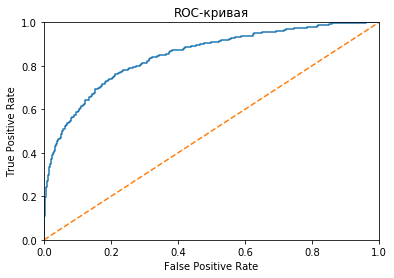

In [35]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

# < постройте график >
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >

plt.show()

### Вывод

Был учтен баланс классов и обучены различные модели. Показатели всех моделей выросли относительно предыдущей главы. Лучше всего себя показала модель Случайный лес, обученной на уменьшенной выборке. Получилось добиться метрик F1=0.61 и ROC-AUC = 0.85, что значительно превышает качество случайного предсказания, что видно на графике.

# 4. Тестирование модели

Проведем финальное тестирование.

In [36]:
model_test = RandomForestClassifier(random_state=12345, n_estimators=29,  max_depth=8)
model_test.fit(features_downsampled, target_downsampled)
predicted_test = model_test.predict(features_test)
print("Правильность =", round(accuracy_score(target_test, predicted_test), 2))
print("Точность =", round(precision_score(target_test, predicted_test), 2))
print("Полнота =", round(recall_score(target_test, predicted_test), 2))
print("F1 =", round(f1_score(target_test, predicted_test), 2))

Правильность = 0.83
Точность = 0.58
Полнота = 0.73
F1 = 0.65


Дополнительно рассмотрим обучение модели на выборке трейн+валидация:

In [37]:
model_test_vt = RandomForestClassifier(random_state=12345, n_estimators=29,  max_depth=8)
model_test_vt.fit(features_valid_train, target_valid_train)
predicted_test_vt = model_test_vt.predict(features_test)
print("Правильность =", round(accuracy_score(target_test, predicted_test_vt), 2))
print("Точность =", round(precision_score(target_test, predicted_test_vt), 2))
print("Полнота =", round(recall_score(target_test, predicted_test_vt), 2))
print("F1 =", round(f1_score(target_test, predicted_test_vt), 2))

Правильность = 0.3
Точность = 0.19
Полнота = 0.69
F1 = 0.3


Поскольку выборка валид+трейн не масштабирована и не подлежала уменьшению - показатели низкие. Остановимся на предыдущей модели (model_test).

In [38]:
probabilities_test = model_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8679811018826379

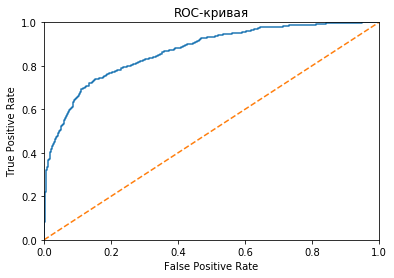

In [39]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# < постройте график >
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >

plt.show()

### Вывод

В ходе проделанной работы мы обучили достаточно качественную модель на основе случайного леса, были подобраны оптимальные параметры, уменьшена выборка, учтен дисбаланс классов. Благодаря этому удалось достич параметра F1=0.65 на тестовой выборке, ROC-AUC =0.868, что значительно превосходит случайное предсказание.